#### **Import Libraries**

In [1]:
import jax 
import jax.numpy as jnp 
import matplotlib.pyplot as plt 
from functools import partial 
import numpy as np 

#### **Folder**

In [2]:
figure_folder = './../../../../instrumental_llms/figures/'

#### **Set Up Plotting**

In [3]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn-v0_8-dark-palette')

from matplotlib import font_manager 
locations = './../../../styles/Newsreader'
font_files = font_manager.findSystemFonts(fontpaths=locations)
print(locations)
print(font_files[0])
for f in font_files: 
    font_manager.fontManager.addfont(f)
plt.rcParams["font.family"] = "Newsreader"

./../../../styles/Newsreader
/home/ubuntu/llmft/styles/Newsreader/static/Newsreader_60pt/Newsreader_60pt-ExtraLightItalic.ttf


#### **Simulation**

In [4]:
def simulate(n, key):

    # Split Keys
    k1, k2, k3, k4, k5 = jax.random.split(key, 5)

    # Sample Instrument
    z = jax.random.bernoulli(k1, shape=(n,1))

    # First Stage 
    exz1 = jnp.full(shape=(n,1), fill_value=0.7)
    exz0 = jnp.full(shape=(n,1), fill_value=0.2)
    exz = z*exz1 + (1-z)*exz0
    ex = 0.5*exz1 + 0.5*exz0

    # First Stage With Noise
    exz1_noise = exz1 + jax.random.uniform(k2, minval=0., maxval=0.1, shape=(n,1))
    exz0_noise = exz0 + jax.random.uniform(k3, minval=0., maxval=0.1, shape=(n,1))
    exz_noise = z*exz1_noise + (1-z)*exz0_noise
    ex_noise = 0.5*exz1_noise + 0.5*exz0_noise

    # Treatment Variable
    pd = exz1*z + exz0*(1-z)
    d = jax.random.bernoulli(k4, p=exz1*z + exz0*(1-z), shape=(n,1)).reshape(-1,1)

    # Outcome Variable
    y = 1.*d + 0.1*jax.random.normal(k5, shape=(n,1))

    # # Construct Residauls
    residuals_noise = exz_noise - ex_noise
    residuals = exz - ex

    oracle_estimate = jnp.linalg.lstsq(jnp.hstack((jnp.ones_like(residuals), residuals)), y)[0]
    noise_estimate = jnp.linalg.lstsq(jnp.hstack((jnp.ones_like(residuals_noise), residuals_noise)), y)[0]
    return oracle_estimate, noise_estimate, residuals.reshape(-1,), residuals_noise.reshape(-1,), y.reshape(-1,)


#### **Run Simulation**

In [7]:
oracle_estimate, noise_estimate, residuals_oracle, residuals_noise, y = simulate(500, jax.random.PRNGKey(0))
print(oracle_estimate)
print(noise_estimate)

[[0.4734181]
 [1.0456077]]
[[0.47233063]
 [1.0334489 ]]


#### **Plot**

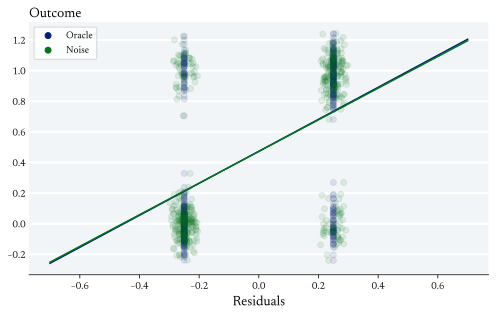

: 

In [8]:
xs = jnp.linspace(-0.7, 0.7, 1000).reshape(-1,1)
xs = jnp.hstack((jnp.ones_like(xs), xs))
yhat_oracle = xs @ oracle_estimate 
yhat_noise = xs @ noise_estimate
fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))

# Plot customizations
for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)
ax.text(0., 1.02, s='Outcome', transform=ax.transAxes, size=14)
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)
plt.scatter(residuals_oracle, y, alpha=0.1, label='Oracle')
plt.scatter(residuals_noise, y, alpha=0.1, label='Noise')
plt.plot(xs[:,1], yhat_oracle)
plt.plot(xs[:,1], yhat_noise)
plt.xlabel('Residuals', size=14)
# Create the legend with full color for labels
legend = plt.legend()
for handle in legend.legend_handles:
    handle.set_alpha(1)  # Set the alpha of the legend handles to 1
plt.show()